In [2]:
!pip install -q git+https://github.com/openai/whisper.git  # For audio transcription
!pip install -q transformers  # For language models
!pip install -q sentencepiece  # For tokenization
!pip install -q datasets  # For data handling
!pip install -q evaluate  # For evaluation metrics
!pip install -q lightgbm  # For gradient boosting
!pip install -q torchaudio  # For audio processing
!pip install -q sentence-transformers  # For semantic embeddings


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 6.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.4 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12=

In [3]:
import os
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
import evaluate
import math
import matplotlib.pyplot as plt
import seaborn as sns

2025-05-06 20:48:56.021073: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746564536.221726      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746564536.280875      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
DATA_PATH = "/kaggle/input/shl-hiring-assessment/Dataset" 
AUDIO_TRAIN = os.path.join(DATA_PATH, "audios/train")
AUDIO_TEST = os.path.join(DATA_PATH, "audios/test")

# Load CSV files
train_df = pd.read_csv(os.path.join(DATA_PATH, "train.csv"))
test_df = pd.read_csv(os.path.join(DATA_PATH, "test.csv"))

# Update filepaths
train_df["filepath"] = train_df["filename"].apply(lambda x: os.path.join(AUDIO_TRAIN, x))
test_df["filepath"] = test_df["filename"].apply(lambda x: os.path.join(AUDIO_TEST, x))

print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")

Training data shape: (444, 3)
Testing data shape: (204, 2)


In [ ]:
# # Load Whisper model for transcription -- no need to run again, I have saved it locally from my first non-persistent session, uploaded as input.
import whisper
device = "cuda" if torch.cuda.is_available() else "cpu"
whisper_model = whisper.load_model("medium", device=device)

def transcribe_audio(path):
    try:
        result = whisper_model.transcribe(path, language="en")
        return result["text"]
    except Exception as e:
        return ""

# # Transcribe audio files (this step takes a long time)
tqdm.pandas()
train_df["transcript"] = train_df["filepath"].progress_apply(transcribe_audio)
test_df["transcript"] = test_df["filepath"].progress_apply(transcribe_audio)

# # Save transcripts to avoid re-transcribing
train_df.to_csv("train_with_transcripts.csv", index=False)
test_df.to_csv("test_with_transcripts.csv", index=False)


/usr/local/lib/python3.11/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)
  0%|        

In [4]:
train_df = pd.read_csv("/kaggle/input/notebook4886a04211/train_with_transcripts.csv")
test_df = pd.read_csv("/kaggle/input/notebook4886a04211/test_with_transcripts.csv")

print("Loading pre-transcribed data to skip the time-consuming transcription process")
print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")
print(f"Sample transcript: {train_df['transcript'].iloc[0][:100]}...")

Loading pre-transcribed data to skip the time-consuming transcription process
Training data shape: (444, 4)
Testing data shape: (204, 3)
Sample transcript:  you...


Grammar score statistics:
count    444.000000
mean       3.967342
std        1.048784
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: label, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


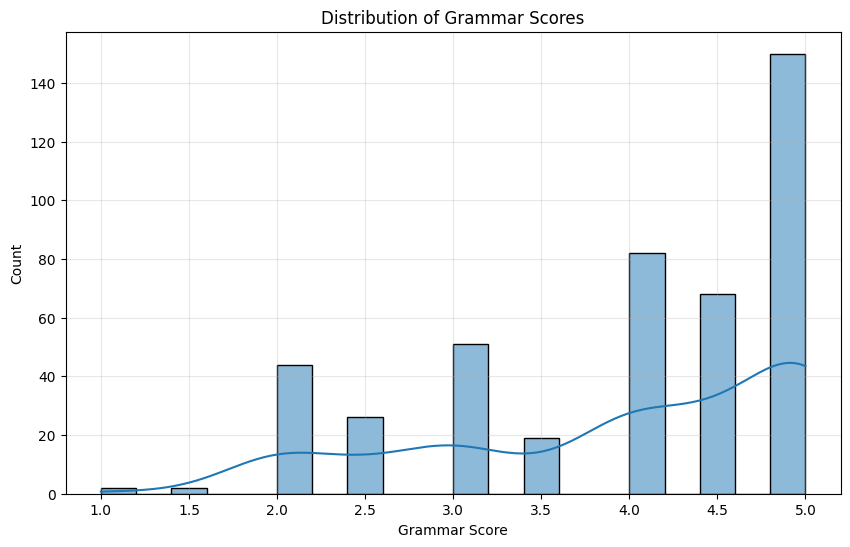


Transcript word count statistics:
count    444.000000
mean      97.684685
std       40.490777
min        1.000000
25%       75.750000
50%      105.500000
75%      126.000000
max      222.000000
Name: transcript_length, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


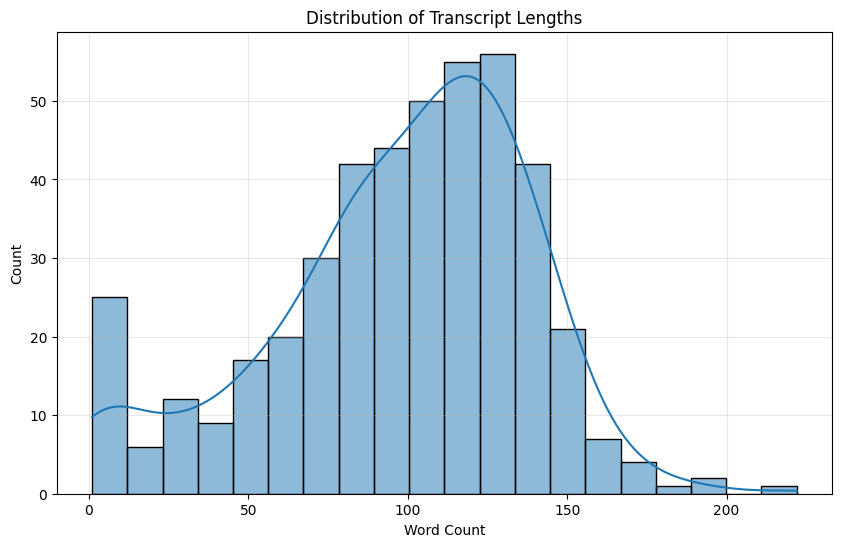

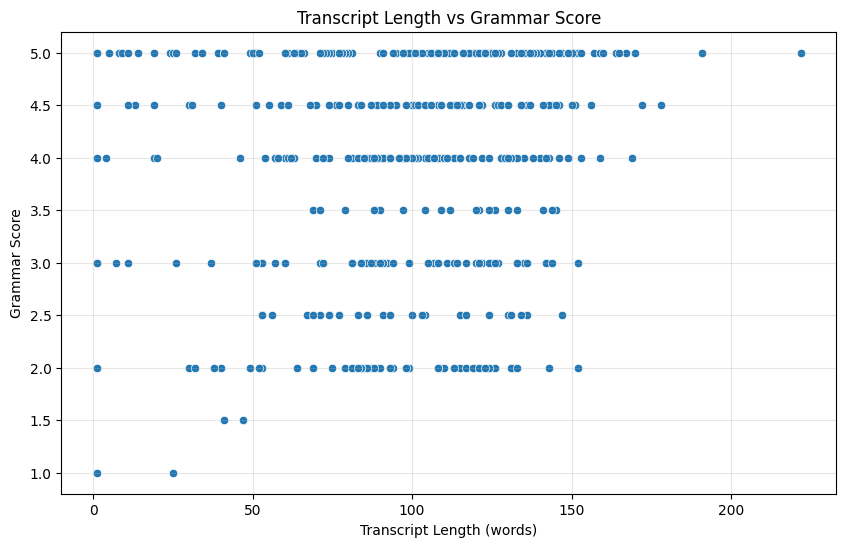

Correlation between transcript length and grammar score: 0.0963


In [5]:
# Basic statistics of the labels
print("Grammar score statistics:")
print(train_df["label"].describe())

# Visualize distribution of grammar scores
plt.figure(figsize=(10, 6))
sns.histplot(train_df["label"], bins=20, kde=True)
plt.title("Distribution of Grammar Scores")
plt.xlabel("Grammar Score")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.show()

# Calculate transcript length statistics
train_df["transcript_length"] = train_df["transcript"].apply(lambda x: len(str(x).split()))
print("\nTranscript word count statistics:")
print(train_df["transcript_length"].describe())

# Visualize transcript length
plt.figure(figsize=(10, 6))
sns.histplot(train_df["transcript_length"], bins=20, kde=True)
plt.title("Distribution of Transcript Lengths")
plt.xlabel("Word Count")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.show()

# Examine correlation between transcript length and grammar score
plt.figure(figsize=(10, 6))
sns.scatterplot(x="transcript_length", y="label", data=train_df)
plt.title("Transcript Length vs Grammar Score")
plt.xlabel("Transcript Length (words)")
plt.ylabel("Grammar Score")
plt.grid(True, alpha=0.3)
plt.show()

print(f"Correlation between transcript length and grammar score: {train_df['transcript_length'].corr(train_df['label']):.4f}")


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

tokenizer = AutoTokenizer.from_pretrained("roberta-large")
model = AutoModel.from_pretrained("roberta-large").to(device)
model.eval()

@torch.no_grad()
def get_meanpool_embedding(text):
    # Handle empty transcript
    if not isinstance(text, str) or text.strip() == "":
        return np.zeros(model.config.hidden_size)
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256).to(device)
    outputs = model(**inputs)
    last_hidden = outputs.last_hidden_state
    mask = inputs['attention_mask'].unsqueeze(-1).expand(last_hidden.shape)
    summed = torch.sum(last_hidden * mask, 1)
    counted = torch.clamp(mask.sum(1), min=1e-9)
    mean_emb = summed / counted
    return mean_emb.cpu().numpy().flatten()

Using device: cuda


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Generate embeddings
print("Generating RoBERTa embeddings...")
tqdm.pandas()
train_df["embedding"] = train_df["transcript"].progress_apply(get_meanpool_embedding)
test_df["embedding"] = test_df["transcript"].progress_apply(get_meanpool_embedding)

Generating RoBERTa embeddings...


100%|██████████| 204/204 [00:06<00:00, 32.62it/s]


Correlation between word_count and grammar score: 0.0962
Correlation between char_count and grammar score: 0.1216
Correlation between avg_word_len and grammar score: 0.0756
Correlation between sentence_count and grammar score: 0.1669
Correlation between avg_sent_len and grammar score: -0.1668


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


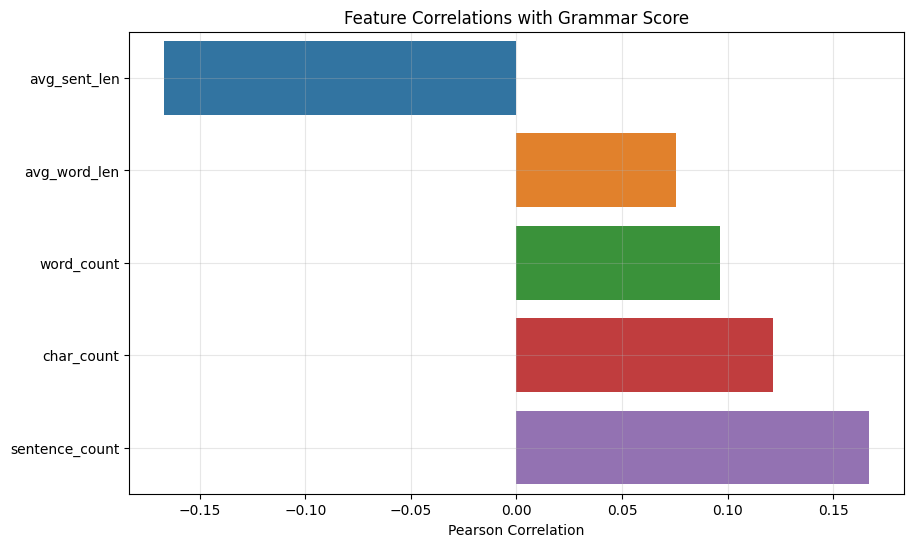

In [8]:
def transcript_features(text):
    if not isinstance(text, str):
        return pd.Series([0, 0, 0, 0, 0])
    text = text.strip()
    if not text:
        return pd.Series([0, 0, 0, 0, 0])
    
    words = text.split()
    sentences = text.split('.')
    sentences = [s.strip() for s in sentences if s.strip()]
    
    # Average sentence length (in words)
    avg_sent_len = np.mean([len(s.split()) for s in sentences]) if sentences else 0
    
    return pd.Series([
        len(words),                # word count
        len(text),                 # char count
        np.mean([len(w) for w in words]) if words else 0,  # average word length
        len(sentences),           # sentence count
        avg_sent_len              # average sentence length
    ])

feature_cols = ["word_count", "char_count", "avg_word_len", "sentence_count", "avg_sent_len"]
for df in [train_df, test_df]:
    df[feature_cols] = df["transcript"].apply(transcript_features)

# Display feature correlations with grammar score
feature_corrs = []
for col in feature_cols:
    corr = train_df[col].corr(train_df["label"])
    feature_corrs.append((col, corr))
    print(f"Correlation between {col} and grammar score: {corr:.4f}")

# Visualize feature correlations
plt.figure(figsize=(10, 6))
feature_names, corrs = zip(*sorted(feature_corrs, key=lambda x: x[1]))
sns.barplot(x=list(corrs), y=list(feature_names))
plt.title("Feature Correlations with Grammar Score")
plt.xlabel("Pearson Correlation")
plt.grid(True, alpha=0.3)
plt.show()

In [10]:
def join_feat_emb(df):
    embs = np.vstack(df["embedding"].values)
    feats = df[feature_cols].values
    return np.hstack([embs, feats])

X = join_feat_emb(train_df)
y = train_df["label"].values
X_test = join_feat_emb(test_df)

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
model_lgb = lgb.LGBMRegressor(
    n_estimators=5000,
    learning_rate=0.01,
    num_leaves=128,
    max_depth=12,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=-1 
)

model_lgb.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(50, verbose=False)]
)

# Calculate RMSE on training data
y_pred_train = model_lgb.predict(X_train)
train_rmse = math.sqrt(mean_squared_error(y_train, y_pred_train))
print(f"Training RMSE: {train_rmse:.4f}")

# Calculate RMSE on validation data
y_pred_val = model_lgb.predict(X_val)
val_rmse = math.sqrt(mean_squared_error(y_val, y_pred_val))
print(f"Validation RMSE: {val_rmse:.4f}")

# Calculate Pearson correlation
pearson = evaluate.load("pearsonr")
score = pearson.compute(predictions=y_pred_val, references=y_val)
print(f"Validation Pearson correlation: {score['pearsonr']:.4f}")

# Generate predictions for test set
test_pred = model_lgb.predict(X_test)
submission = pd.DataFrame({
    "filename": test_df["filename"],
    "label": test_pred
})
submission.to_csv("submission_roberta.csv", index=False)
print("RoBERTa model submission file saved.")

Training RMSE: 0.2238
Validation RMSE: 0.8581


Validation Pearson correlation: 0.6809
RoBERTa model submission file saved.


In [12]:
np.save('y_val.npy', y_val)
np.save('y_pred_val_roberta.npy', y_pred_val)
print("Saved y_val and y_pred_val_roberta")

Saved y_val and y_pred_val_roberta


In [13]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-mpnet-base-v2', device=device)

def get_sbert_embedding(text):
    if not isinstance(text, str) or text.strip() == "":
        return np.zeros(model.get_sentence_embedding_dimension())
    return model.encode(text, show_progress_bar=False)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [14]:
print("Generating SBERT embeddings...")
tqdm.pandas()
train_df["embedding"] = train_df["transcript"].progress_apply(get_sbert_embedding)
test_df["embedding"] = test_df["transcript"].progress_apply(get_sbert_embedding)

# Note: We're reusing the features calculated earlier (word_count, char_count, etc.)
# but now combining them with SBERT embeddings instead of RoBERTa embeddings

# Merge SBERT embeddings with previously calculated features
X = join_feat_emb(train_df)
y = train_df["label"].values
X_test = join_feat_emb(test_df)

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Generating SBERT embeddings...


100%|██████████| 204/204 [00:02<00:00, 71.18it/s]


In [15]:
model_lgb = lgb.LGBMRegressor(
    n_estimators=5000,
    learning_rate=0.01,
    num_leaves=128,
    max_depth=12,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=-1 
)

model_lgb.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(50, verbose=False)]
)

# Calculate RMSE on training data
y_pred_train = model_lgb.predict(X_train)
train_rmse = math.sqrt(mean_squared_error(y_train, y_pred_train))
print(f"Training RMSE: {train_rmse:.4f}")

# Calculate RMSE on validation data
y_pred_val = model_lgb.predict(X_val)
val_rmse = math.sqrt(mean_squared_error(y_val, y_pred_val))
print(f"Validation RMSE: {val_rmse:.4f}")

# Calculate Pearson correlation
pearson = evaluate.load("pearsonr")
score = pearson.compute(predictions=y_pred_val, references=y_val)
print(f"Validation Pearson correlation: {score['pearsonr']:.4f}")

# Generate predictions for test set
test_pred = model_lgb.predict(X_test)
submission = pd.DataFrame({
    "filename": test_df["filename"],
    "label": test_pred
})
submission.to_csv("submission_sbert.csv", index=False)
print("SBERT model submission file saved.")

Training RMSE: 0.1887
Validation RMSE: 0.9562
Validation Pearson correlation: 0.5936
SBERT model submission file saved.


In [16]:
np.save('y_pred_val_sbert.npy', y_pred_val)  # y_pred_val for SBERT!
print("Saved y_pred_val_sbert")

Saved y_pred_val_sbert


In [17]:
sub1 = pd.read_csv('submission_roberta.csv')
sub2 = pd.read_csv('submission_sbert.csv')

# Ensure filenames are aligned
sub1 = sub1.sort_values('filename')
sub2 = sub2.sort_values('filename')
assert all(sub1['filename'] == sub2['filename']), "Filename mismatch between submissions"

# Create ensemble with equal weights
blended = pd.DataFrame({
    "filename": sub1["filename"],
    "label": 0.5 * sub1["label"] + 0.5 * sub2["label"]
})

# Save final submission
blended.to_csv("submission_blend.csv", index=False)
print("Ensembled submission file saved.")

# Display sample predictions
print("\nSample predictions:")
print(blended.head())

Ensembled submission file saved.

Sample predictions:
           filename     label
203  audio_1001.wav  4.426904
90   audio_1006.wav  4.034858
79   audio_1011.wav  4.355489
36   audio_1025.wav  3.689866
1    audio_1028.wav  2.868208


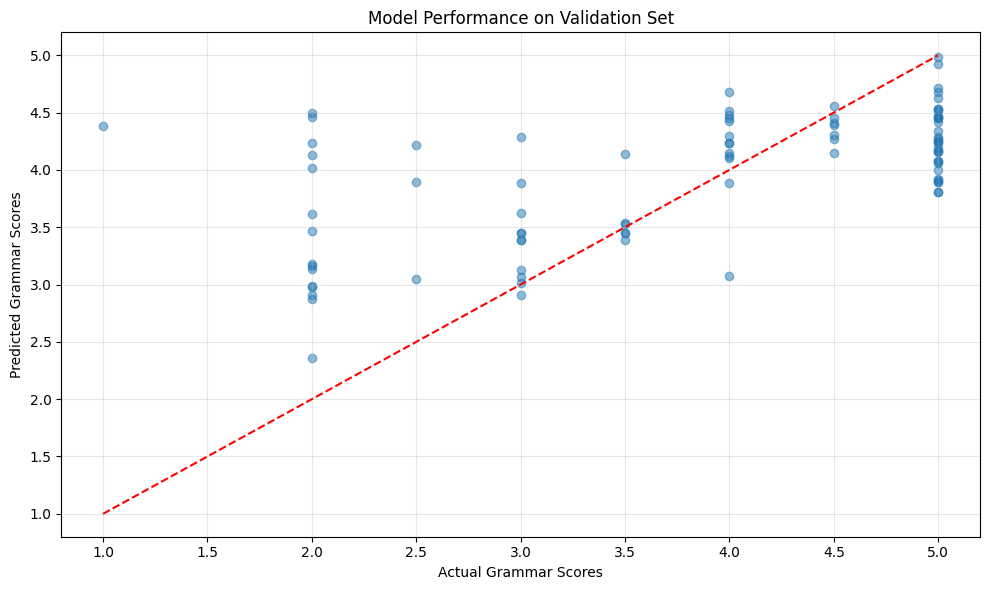

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


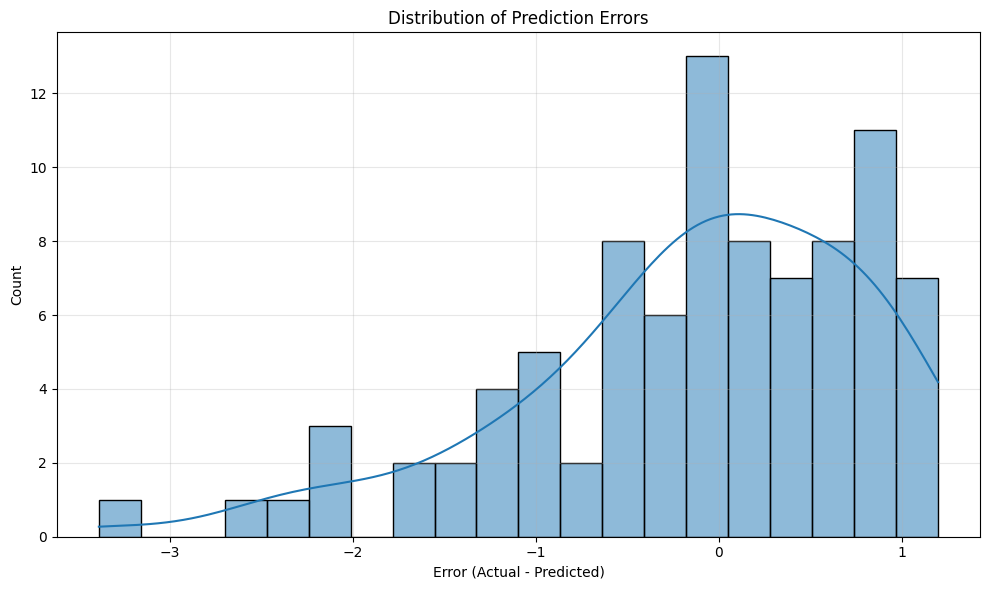

R² Score: 0.3245

Error analysis by score range:
                 error                
                  mean       std count
actual                                
(0.996, 1.8] -3.385787       NaN     1
(1.8, 2.6]   -1.426153  0.638457    18
(2.6, 3.4]   -0.417418  0.405848    11
(3.4, 4.2]   -0.164059  0.363156    19
(4.2, 5.0]    0.611345  0.357190    40

Model Performance Summary:
Training RMSE: 0.1887
Validation RMSE: 0.9562
Pearson Correlation: 0.5936
R² Score: 0.3245


/tmp/ipykernel_31/2869647916.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_score = error_df.groupby(pd.cut(error_df['actual'], bins=5)).agg({
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_val, alpha=0.5)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--')
plt.xlabel('Actual Grammar Scores')
plt.ylabel('Predicted Grammar Scores')
plt.title('Model Performance on Validation Set')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Prediction error analysis
errors = y_val - y_pred_val
plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=20, kde=True)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate R² score
r2 = r2_score(y_val, y_pred_val)
print(f"R² Score: {r2:.4f}")

# Error analysis by actual score range
error_df = pd.DataFrame({
    'actual': y_val,
    'predicted': y_pred_val,
    'error': errors
})

error_by_score = error_df.groupby(pd.cut(error_df['actual'], bins=5)).agg({
    'error': ['mean', 'std', 'count']
})
print("\nError analysis by score range:")
print(error_by_score)

# Summary of model performance metrics
print("\nModel Performance Summary:")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Pearson Correlation: {score['pearsonr']:.4f}")
print(f"R² Score: {r2:.4f}")